In [622]:
import nltk
import pandas as pd
import chardet
from matplotlib import pyplot as plt
import re
import seaborn as sns
import numpy as np
from statsmodels import api as sm
from wordcloud import WordCloud
from collections import Counter
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
import networkx as nx

In [ ]:
nltk.

In [114]:
sns.set_theme(color_codes = True)

### Inputs

In [12]:
lenguage = 'english'



plt.rcParams['figure.figsize'] = (10, 5)

### Detect Encoding

In [3]:
with open('Harry Potter and the Sorcerer.txt', 'rb') as f:
    
    e = chardet.detect(f.read())
    
    print(
        e
    )

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


### Load File

In [4]:
with open('Harry Potter and the Sorcerer.txt', 'r', encoding = e['encoding']) as f:
    
    text = f.read()
    
print(text[:200])

Harry Potter and the Sorcerer's Stone 

CHAPTER ONE 

THE BOY WHO LIVED 

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. Th


### Word Cloud

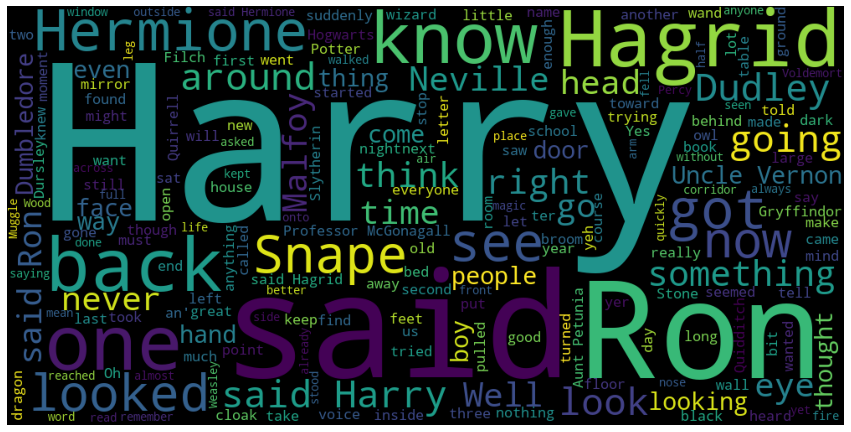

In [367]:
wc = WordCloud(width = 1000, height = 500).generate_from_text(text)

plt.figure(figsize=(15,8))

plt.imshow(wc)
plt.axis("off")
plt.show()

### Split chapters

In [274]:
chapters = re.split('\n\nCHAPTER \w+ \n\n', text)[1:]

chapters_pd = pd.DataFrame(
    ['\n'.join(i.split('\n\n')[1:]) for i in chapters],
    index = [i.split('\n\n')[0] for i in chapters]

)

chapters_pd

,0
THE BOY WHO LIVED,"Mr. and Mrs. Dursley, of number four, Privet D..."
THE VANISHING GLASS,Nearly ten years had passed since the Dursleys...
THE LETTERS FROM NO ONE,The escape of the Brazilian boa constrictor ea...
THE KEEPER OF THE KEYS,BOOM. They knocked again. Dudley jerked awake....
DIAGON ALLEY,Harry woke early the next morning. Although he...
THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS,Harry's last month with the Dursleys wasn't fu...
THE SORTING HAT,"The door swung open at once. A tall, black-hai..."
THE POTIONS MASTER,"There, look."" \n""Where?"" \n""Next to the tall k..."
HALLOWEEN,Malfoy couldn't believe his eyes when he saw t...
QUIDDITCH,"As they entered November, the weather turned v..."


Create tokens

In [275]:
stop_words = set(nltk.corpus.stopwords.words(lenguage))

chapters_token = [
    nltk.tokenize.word_tokenize(s.lower()) 
    for s in chapters if s not in stop_words
]

Create gensim dictionary

In [276]:
dictionary = gensim.corpora.Dictionary(chapters_token)

Create Corpus

In [278]:
corpus = [dictionary.doc2bow(s) for s in chapters_token]

### TF IDF

In [281]:
tfidf = gensim.models.tfidfmodel.TfidfModel(corpus)

In [339]:
n_chapter = 5
n = 10

for i in pd.DataFrame(tfidf[corpus[n_chapter]]).sort_values(1, ascending = False)[:n].iterrows():
    print(f'{dictionary[i[0]]}: {i[1][1]:.3f}')

undursleyish: 0.340
wanted: 0.242
repeated: 0.233
sleeve: 0.227
along: 0.151
uneasy: 0.151
louder: 0.148
stupid: 0.132
youknow-who: 0.132
well: 0.126


THE BOY WHO LIVED 


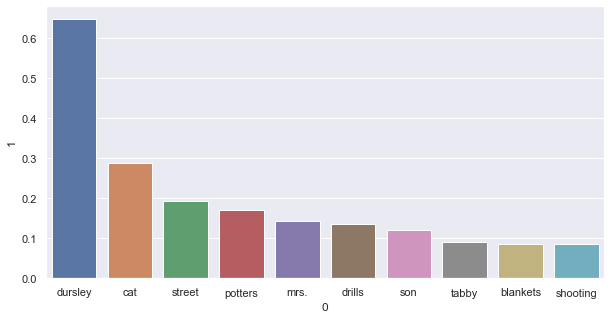

THE VANISHING GLASS 


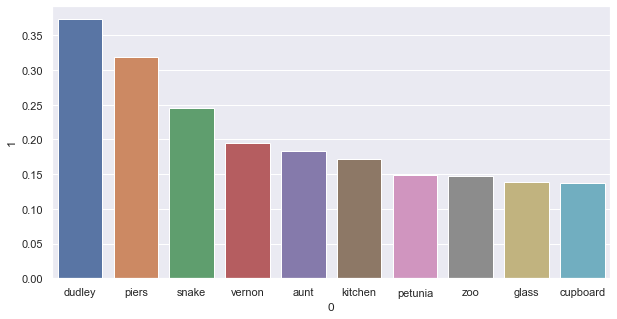

THE LETTERS FROM NO ONE 


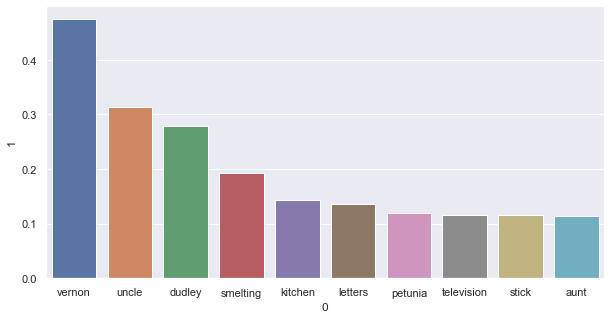

THE KEEPER OF THE KEYS 


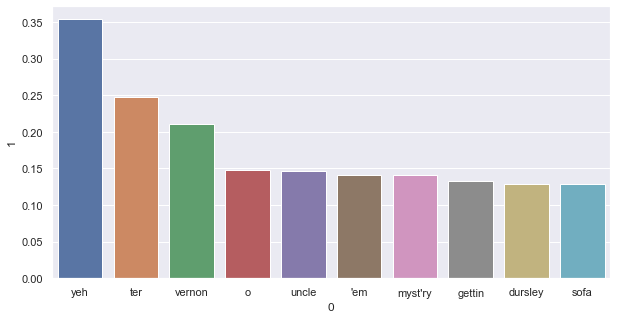

DIAGON ALLEY 


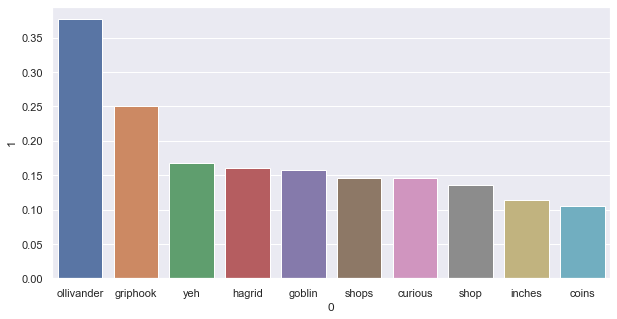

THE JOURNEY FROM PLATFORM NINE AND THREE-QUARTERS 


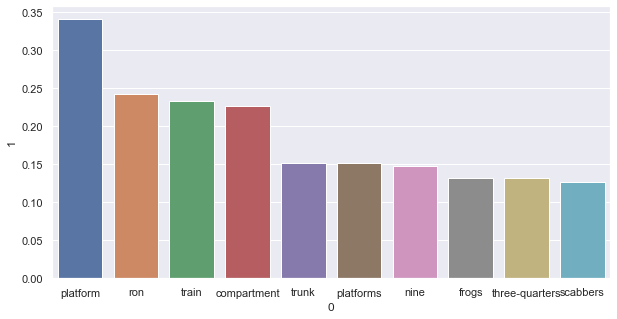

THE SORTING HAT 


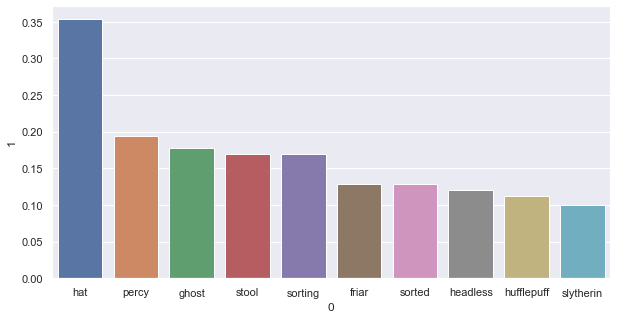

THE POTIONS MASTER 


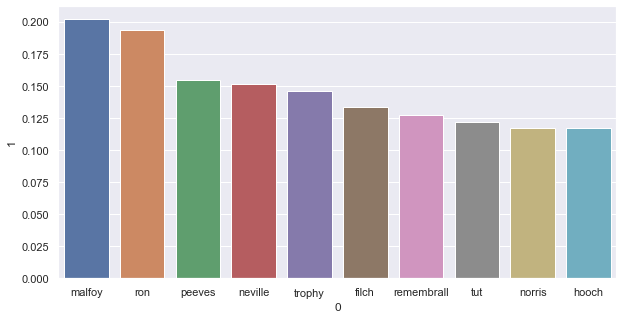

HALLOWEEN 


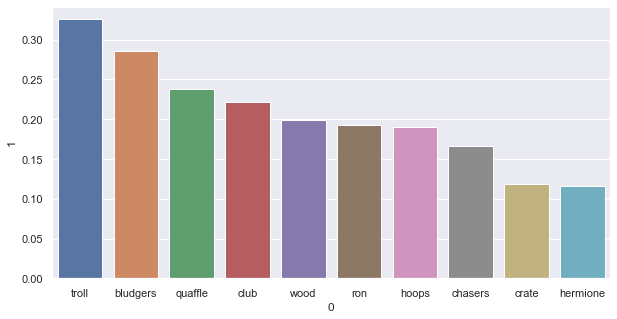

QUIDDITCH 


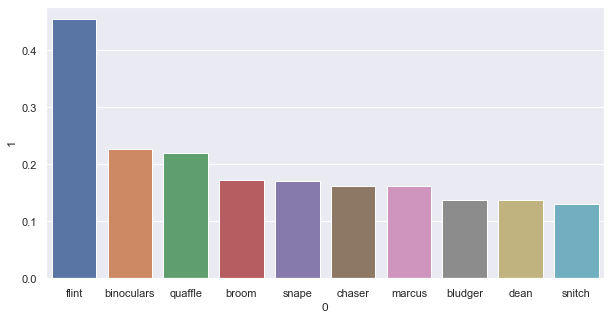

THE MIRROR OF ERISED 


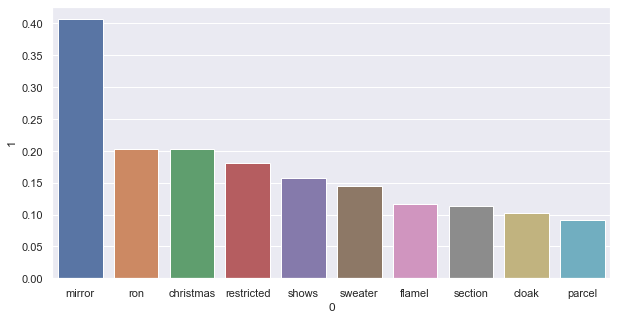

NICOLAS FLAMEL 


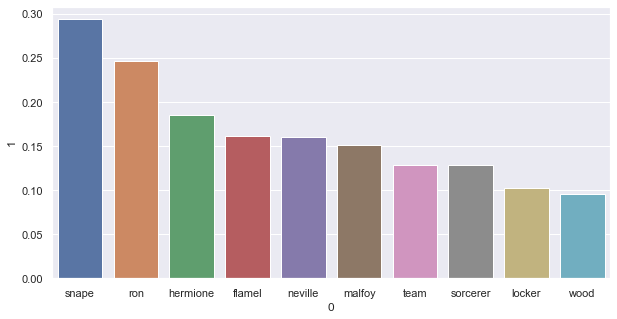

NORBERT THE NORWEGIAN RIDGEBACK 


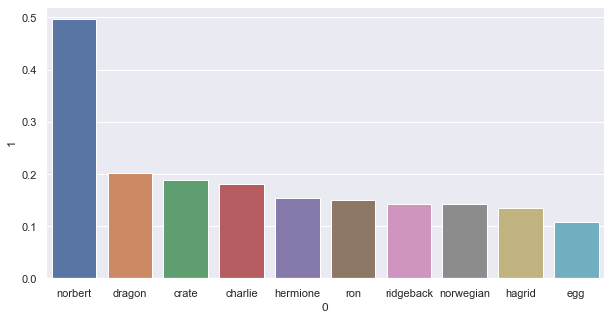

THE FORIBIDDEN FOREST 


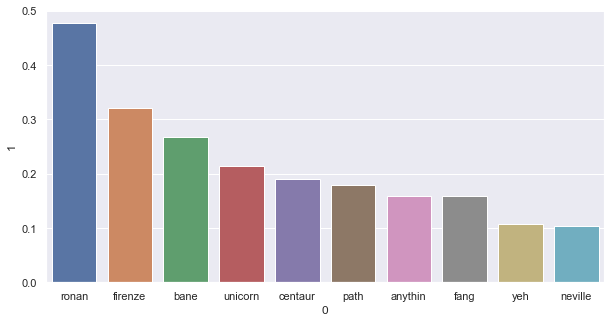

THROUGH THE TRAPDOOR 


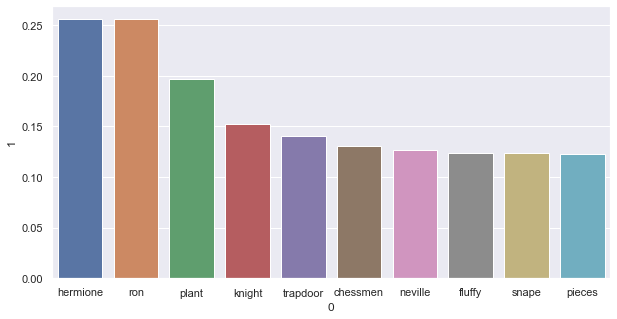

THE MAN WITH TWO FACES It was Quirrell. 


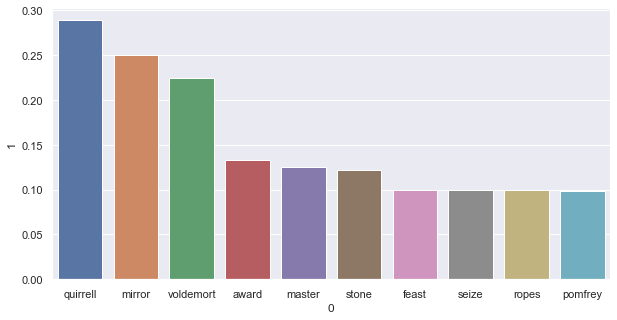

In [356]:
for n_chapter in range(len(corpus)):
    #n_chapter = 2
    n = 10
    
    print(chapters[n_chapter].split('\n')[0])

    df = pd.DataFrame(tfidf[corpus[n_chapter]]).sort_values(1, ascending = False)

    df[0] = df[0].apply(lambda a: dictionary[a])

    sns.barplot(data = df[:n], x = 0, y = 1)

    plt.show()

#### TF IDF Sklearn

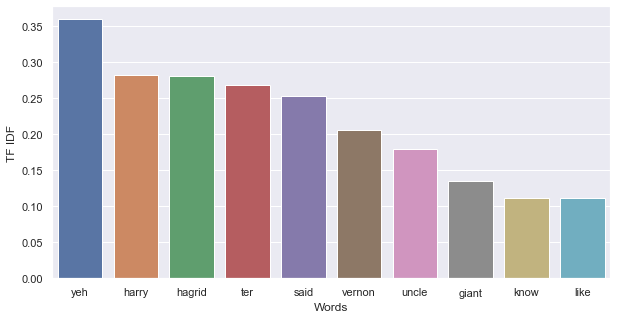

In [405]:
tfidf_vectorizer  = TfidfVectorizer(stop_words = 'english')

tfidf = tfidf_vectorizer.fit_transform(chapters)

n_chapter = 3
n = 10


df = pd.DataFrame(
    {'Words':tfidf_vectorizer.get_feature_names(), 
     'TF IDF':tfidf.toarray()[n_chapter]}
).sort_values('TF IDF', ascending = False)

sns.barplot(data = df[:n], x = 'Words', y = 'TF IDF')

plt.show()

### Word Embedding

In [533]:
fn =  lambda a: [s for s in a if s.isalnum()]

t = [
    fn(nltk.word_tokenize(i.lower())) 
    for i in text.split('\n') if len(i) > 0 and i not in stop_words
]

In [535]:
word2vec = gensim.models.Word2Vec(t, min_count=2)

X = word2vec[word2vec.wv.vocab]
df = pd.DataFrame(X, index = word2vec.wv.vocab)

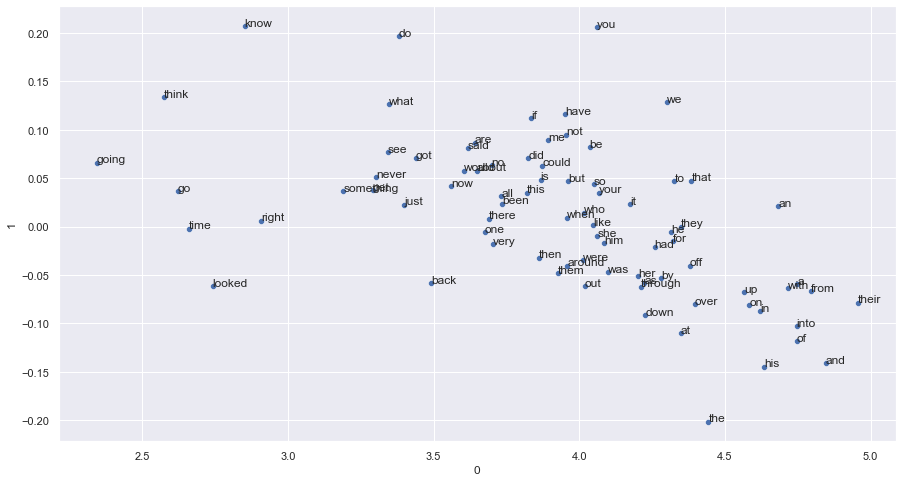

In [588]:
slicer = [a[0] for a in Counter(token).most_common() if a[0] in df.index][:80]

pca = sklearn.decomposition.PCA(n_components=2)

transform = pca.fit_transform(df)

df_new = pd.DataFrame(transform, index=df.index).loc[slicer]

plt.figure(figsize=(15,8))

sns.scatterplot(x = df_new[0], y = df_new[1]
)

for pos, name in zip(df_new.values, slicer):
    
    plt.annotate(name,xy=(pos[0],pos[1]))

plt.show()

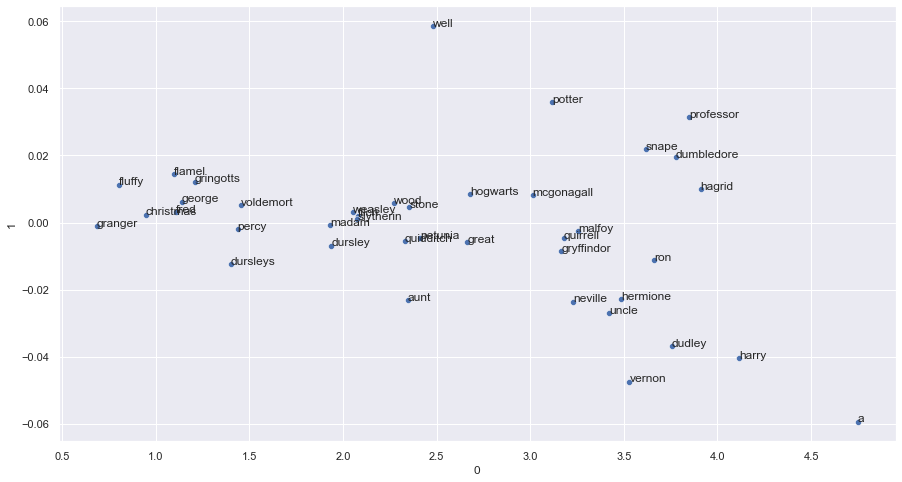

In [589]:
names = [i[0].lower() for i in nltk.pos_tag(token) if i[1] == 'NNP']

slicer = [a[0] for a in Counter(names).most_common() if a[0] in df.index][:40]

pca = sklearn.decomposition.PCA(n_components=2)

transform = pca.fit_transform(df)

df_new = pd.DataFrame(transform, index=df.index).loc[slicer]

plt.figure(figsize=(15,8))

sns.scatterplot(x = df_new[0], y = df_new[1]
)

for pos, name in zip(df_new.values, slicer):
    
    plt.annotate(name,xy=(pos[0],pos[1]))

plt.show()

### Tokenize Text

In [418]:
token = nltk.tokenize.word_tokenize(text, language = lenguage)

token[:5]

['Harry', 'Potter', 'and', 'the', 'Sorcerer']

### Remove punctuation

In [600]:
token = [word for word in token if word.isalnum()]

### Get Frequency distribution

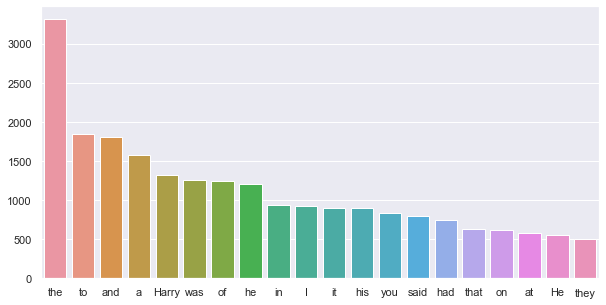

In [364]:
w = Counter(token).most_common()[:20]

sns.barplot(
    x = [a[0] for a in w],
    y = [a[1] for a in w]
)

plt.show()

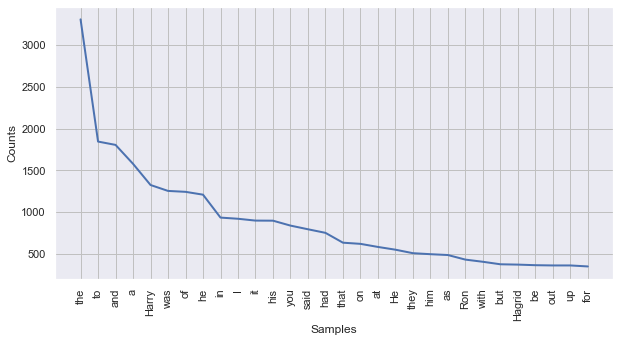

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [177]:
fdist = nltk.probability.FreqDist(token)

fdist.plot(30, cumulative = False)

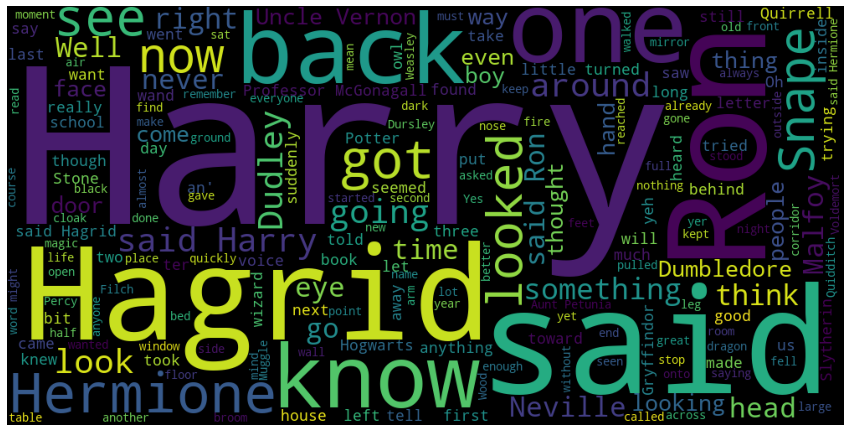

In [366]:
wc = WordCloud(width = 1000, height = 500).generate_from_text(token)

plt.figure(figsize=(15,8))

plt.imshow(wc)
plt.axis("off")
plt.show()

### Zipf's Law

In [159]:
def zipf_law(fdist):
    
    # Sort Frequencies
    freq = np.sort(np.array(
        list(
            fdist.values()
            )
        ))[::-1]
    
    r = np.arange(1, len(freq) + 1)
    
    # Plot Results
    sns.regplot(
        # Frequency
        y = np.log(freq),
        # Rank
        x = np.log(r), 
    )


    plt.ylabel('Log(Frequency)')

    plt.xlabel('Log(r)')

    plt.show()
    
    # Linear Regression
    lm = sm.OLS(
        # Frequency
        np.log(freq),
        # Rank
        np.log(r)
    )

    result = lm.fit()

    print(result.summary())

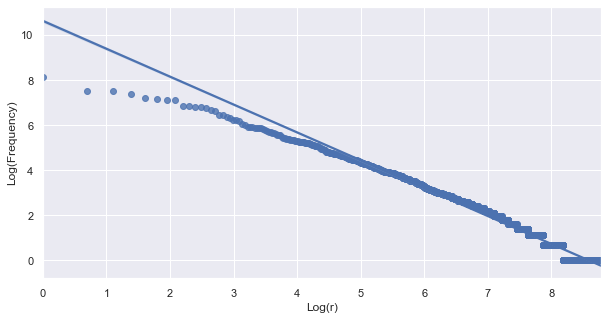

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.269
Model:                            OLS   Adj. R-squared (uncentered):              0.269
Method:                 Least Squares   F-statistic:                              2395.
Date:                Sat, 03 Oct 2020   Prob (F-statistic):                        0.00
Time:                        16:42:51   Log-Likelihood:                         -11250.
No. Observations:                6508   AIC:                                  2.250e+04
Df Residuals:                    6507   BIC:                                  2.251e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [160]:
zipf_law(fdist)

### NER - Named Entity Recognition

In [359]:
ner = nltk.pos_tag(token)

print(ner[:5])

[('Harry', 'NNP'), ('Potter', 'NNP'), ('and', 'CC'), ('the', 'DT'), ('Sorcerer', 'NNP')]


### Remove Stop Words

In [602]:
stop_words = set(nltk.corpus.stopwords.words(lenguage))

filtered_sent=[w for w in token if w not in stop_words]

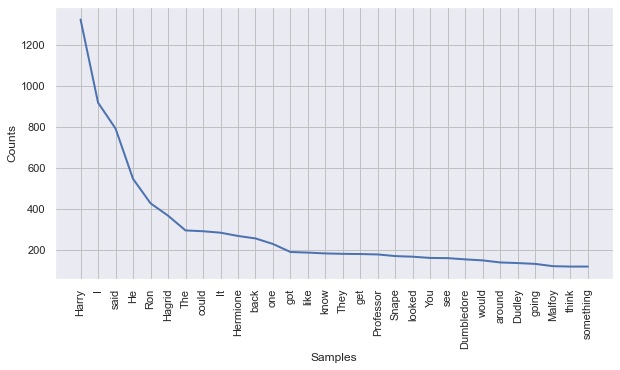

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [603]:
fdist = nltk.probability.FreqDist(filtered_sent)

fdist.plot(30, cumulative = False)

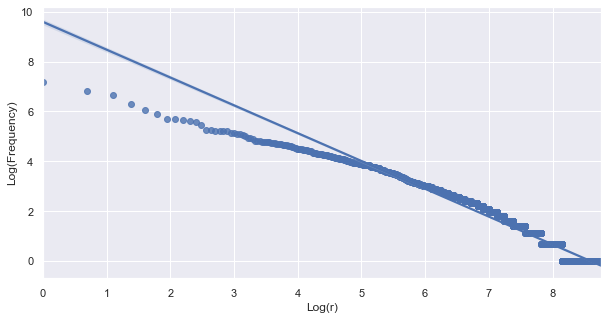

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.279
Model:                            OLS   Adj. R-squared (uncentered):              0.279
Method:                 Least Squares   F-statistic:                              2471.
Date:                Sat, 03 Oct 2020   Prob (F-statistic):                        0.00
Time:                        16:43:08   Log-Likelihood:                         -10427.
No. Observations:                6373   AIC:                                  2.086e+04
Df Residuals:                    6372   BIC:                                  2.086e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [163]:
zipf_law(fdist)

### Stemming

In [164]:
ps = nltk.stem.PorterStemmer()

stemmed_words=[]

for w in filtered_sent:
    
    stemmed_words.append(ps.stem(w))

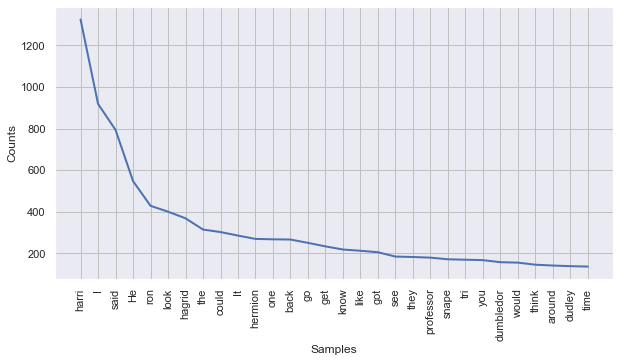

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [165]:
fdist = nltk.probability.FreqDist(stemmed_words)

fdist.plot(30, cumulative = False)

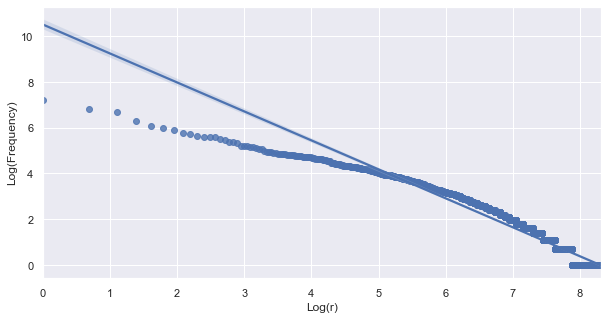

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.352
Model:                            OLS   Adj. R-squared (uncentered):              0.352
Method:                 Least Squares   F-statistic:                              2216.
Date:                Sat, 03 Oct 2020   Prob (F-statistic):                        0.00
Time:                        16:43:32   Log-Likelihood:                         -7306.1
No. Observations:                4080   AIC:                                  1.461e+04
Df Residuals:                    4079   BIC:                                  1.462e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [166]:
zipf_law(fdist)

### Análise de n-grams

In [594]:
vect = CountVectorizer(token, ngram_range = (2, 3))

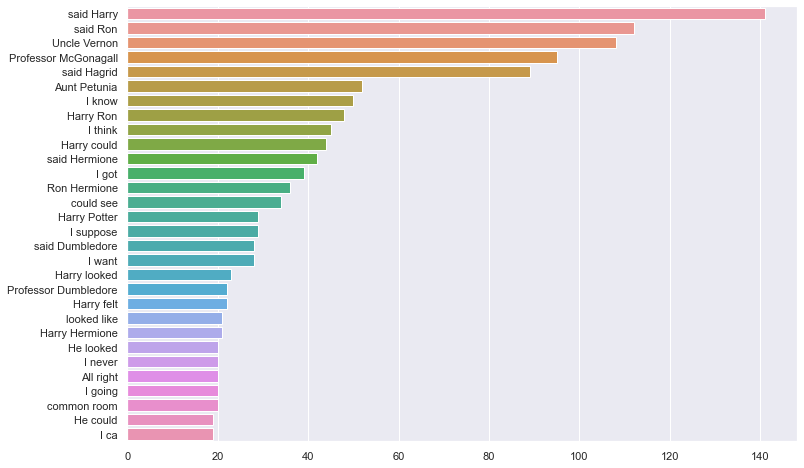

In [620]:
plt.figure(figsize=(12,8))

w = Counter(nltk.ngrams(filtered_sent, 2)).most_common()[:30]

sns.barplot(
    y = [' '.join(a[0]) for a in w],
    x = [a[1] for a in w],orient = 'h'
)

plt.show()

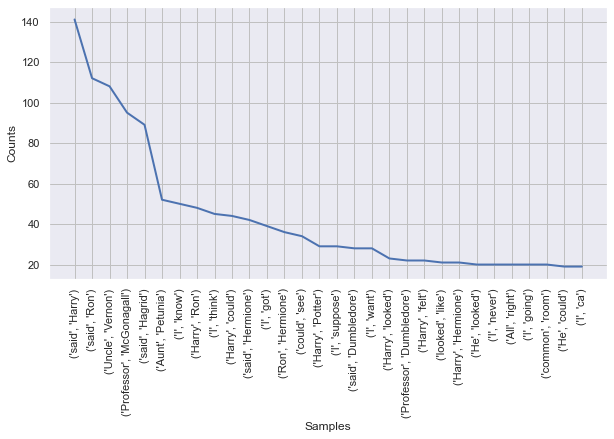

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [604]:
fdist = nltk.probability.FreqDist(nltk.ngrams(filtered_sent, 2))

fdist.plot(30, cumulative = False)

In [635]:
nltk.ngrams(filtered_sent, 2)

<generator object ngrams at 0x1462476d0>

In [657]:
G = nx.Graph()

In [637]:
G.add_edges_from(nltk.ngrams(filtered_sent, 2, ))

In [656]:
Counter(nltk.ngrams(filtered_sent, 2)).most_common()[:100][0][0][0]

('said', 'Harry')

<ipython-input-668-714c96377b89>:14: UserWarning: Matplotlib is currently using ps, which is a non-GUI backend, so cannot show the figure.
  plt.show()


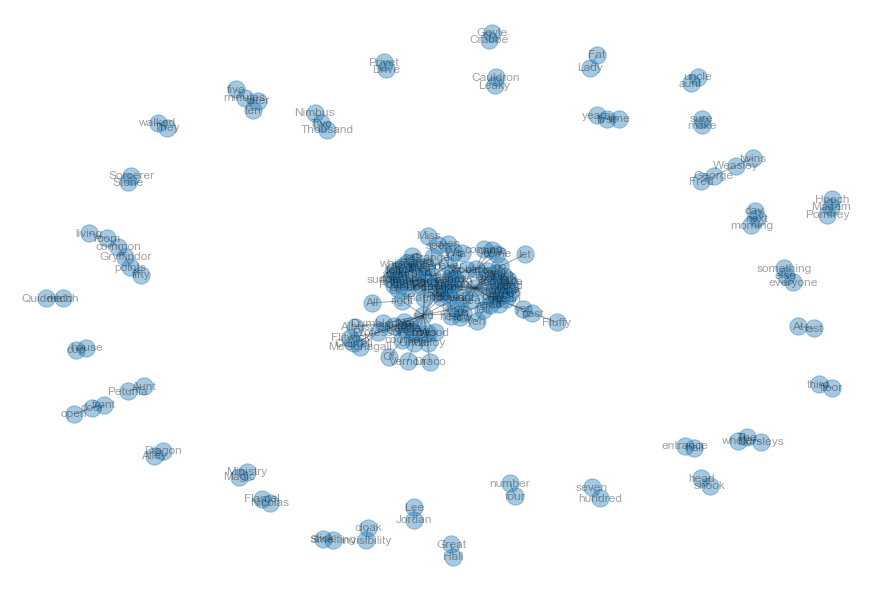

In [668]:
plt.figure(figsize=(12,8))

G = nx.Graph()

G.add_edges_from(
    [
        [i[0][0], i[0][1]]
        for i in Counter(nltk.ngrams(filtered_sent, 2)).most_common()[:200]
    ]
)

nx.draw(G, with_labels=True, alpha=0.4)

plt.show()

In [776]:
n = 100

G = nx.Graph()

for i in Counter(nltk.ngrams(filtered_sent, 2)).most_common()[:n]:
    
    G.add_edge(i[0][0], i[0][1], weight = i[1])
    
degree = [i[0] for i in G.degree if i[1] > 3]

<ipython-input-777-ac637e0b2162>:15: UserWarning: Matplotlib is currently using ps, which is a non-GUI backend, so cannot show the figure.
  plt.show()


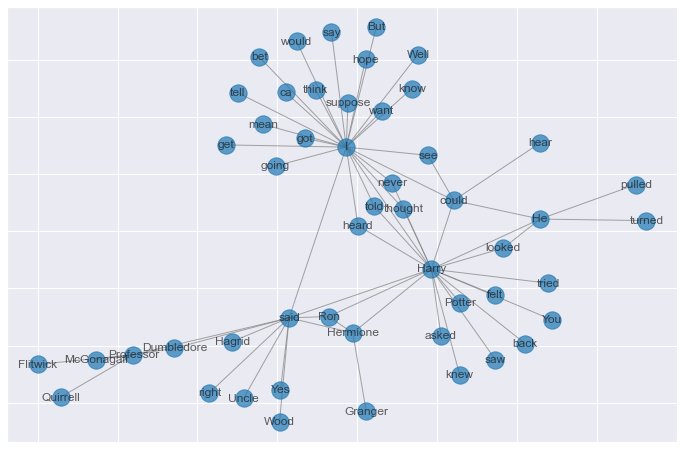

In [777]:
plt.figure(figsize=(12,8))

G = nx.Graph()

for i in Counter(nltk.ngrams(filtered_sent, 2)).most_common()[:n]:
    
    if i[0][0]  in degree or i[0][1] in degree:
        
        G.add_edge(i[0][0], i[0][1], weight = i[1])

    
nx.draw_networkx(G, with_labels=True, alpha=0.7, node_size = 300, edge_color = 'gray')


plt.show()

In [ ]:
nltk.pos_tag()

In [750]:
token_name = [i[0] for i in nltk.pos_tag(token) if i[1] == 'NNP' or i[1] == 'NN']

In [767]:
n = 300

G = nx.Graph()

for i in Counter(nltk.ngrams(token_name, 2)).most_common()[:n]:
    
    G.add_edge(i[0][0], i[0][1], weight = i[1])
    
degree = [i[0] for i in G.degree if i[1] >= 3]

<ipython-input-768-da6ac7cccd66>:15: UserWarning: Matplotlib is currently using ps, which is a non-GUI backend, so cannot show the figure.
  plt.show()


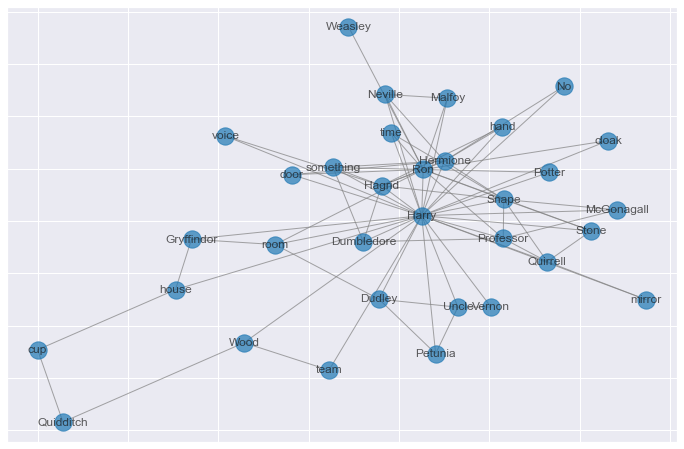

In [768]:
plt.figure(figsize=(12,8))

G = nx.Graph()

for i in Counter(nltk.ngrams(token_name, 2)).most_common()[:n]:
    
    if i[0][0] in degree and i[0][1] in degree:
        
        G.add_edge(i[0][0], i[0][1], weight = i[1])

    
nx.draw_networkx(G, with_labels=True, alpha=0.7, node_size = 300, edge_color = 'gray')


plt.show()

Topic modeling